In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# IMPORTING THE NECESSARY LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold


# LOADING THE DATASET

In [3]:
df_train = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
df_test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

# EXPLORATORY DATA ANALYSIS 

In [4]:
print("Dataset Shape:", df_train.shape)
print(df_train.info())

Dataset Shape: (100000, 76)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11 

Dropping columns with constant values

In [5]:
constant_cols = [col for col in df_train.columns if df_train[col].nunique() == 1]

print("Columns with only one unique value:")
for col in constant_cols:
    print(f"{col}: {df_train[col].unique()[0]}")  

Columns with only one unique value:
IsBetaUser: 0
AutoSampleSubmissionEnabled: 0
IsFlightsDisabled: 0.0


In [6]:
df_train = df_train.drop(columns=constant_cols)

print("Dropped constant columns:", constant_cols)

df_test = df_test.drop(columns=constant_cols)

print("Dropped constant columns:", constant_cols)

Dropped constant columns: ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']
Dropped constant columns: ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']


Output class distribution

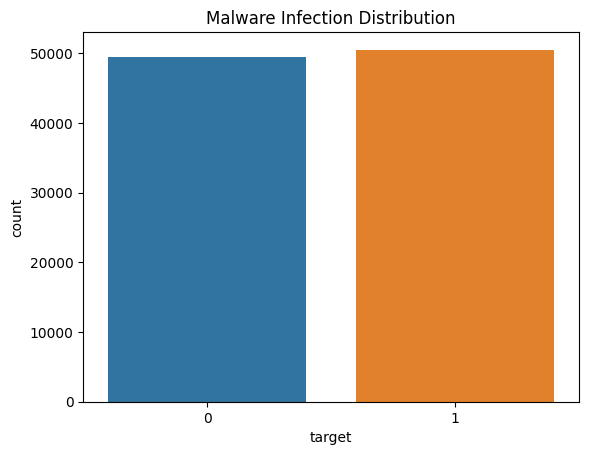

In [7]:
sns.countplot(x='target', data=df_train)
plt.title("Malware Infection Distribution")
plt.show()

In [8]:
infection_rate = df_train['target'].mean()
print(f"Infection Rate: {infection_rate:.2%}")

Infection Rate: 50.52%


Missing values comparision

In [9]:
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False))

                                    Missing Values  Percentage
SMode                                          981       0.981
CityID                                         623       0.623
RegionIdentifier                               559       0.559
IsGamer                                        559       0.559
InternalBatteryNumberOfCharges                 515       0.515
FirmwareManufacturerID                         376       0.376
FirmwareVersionID                              334       0.334
OEMModelID                                     228       0.228
OEMNameID                                      212       0.212
FirewallEnabled                                166       0.166
TotalPhysicalRAMMB                             151       0.151
IsAlwaysOnAlwaysConnectedCapable               134       0.134
OSInstallLanguageID                            113       0.113
SystemVolumeCapacityMB                         110       0.110
PrimaryDiskCapacityMB                          110     

Data type distribution

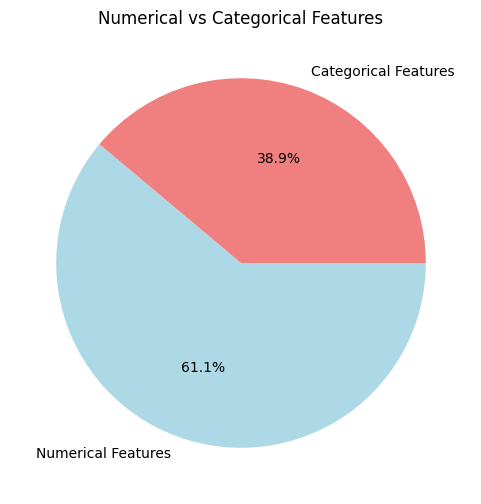

In [10]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('target')

num_cat_counts = [len(numerical_cols), len(categorical_cols)]
labels = ['Numerical Features', 'Categorical Features']
plt.figure(figsize=(6, 6))
plt.pie(num_cat_counts, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'], startangle=140)
plt.title("Numerical vs Categorical Features")
plt.show()

Numerical feature distribution (Skew or Normal distribution)

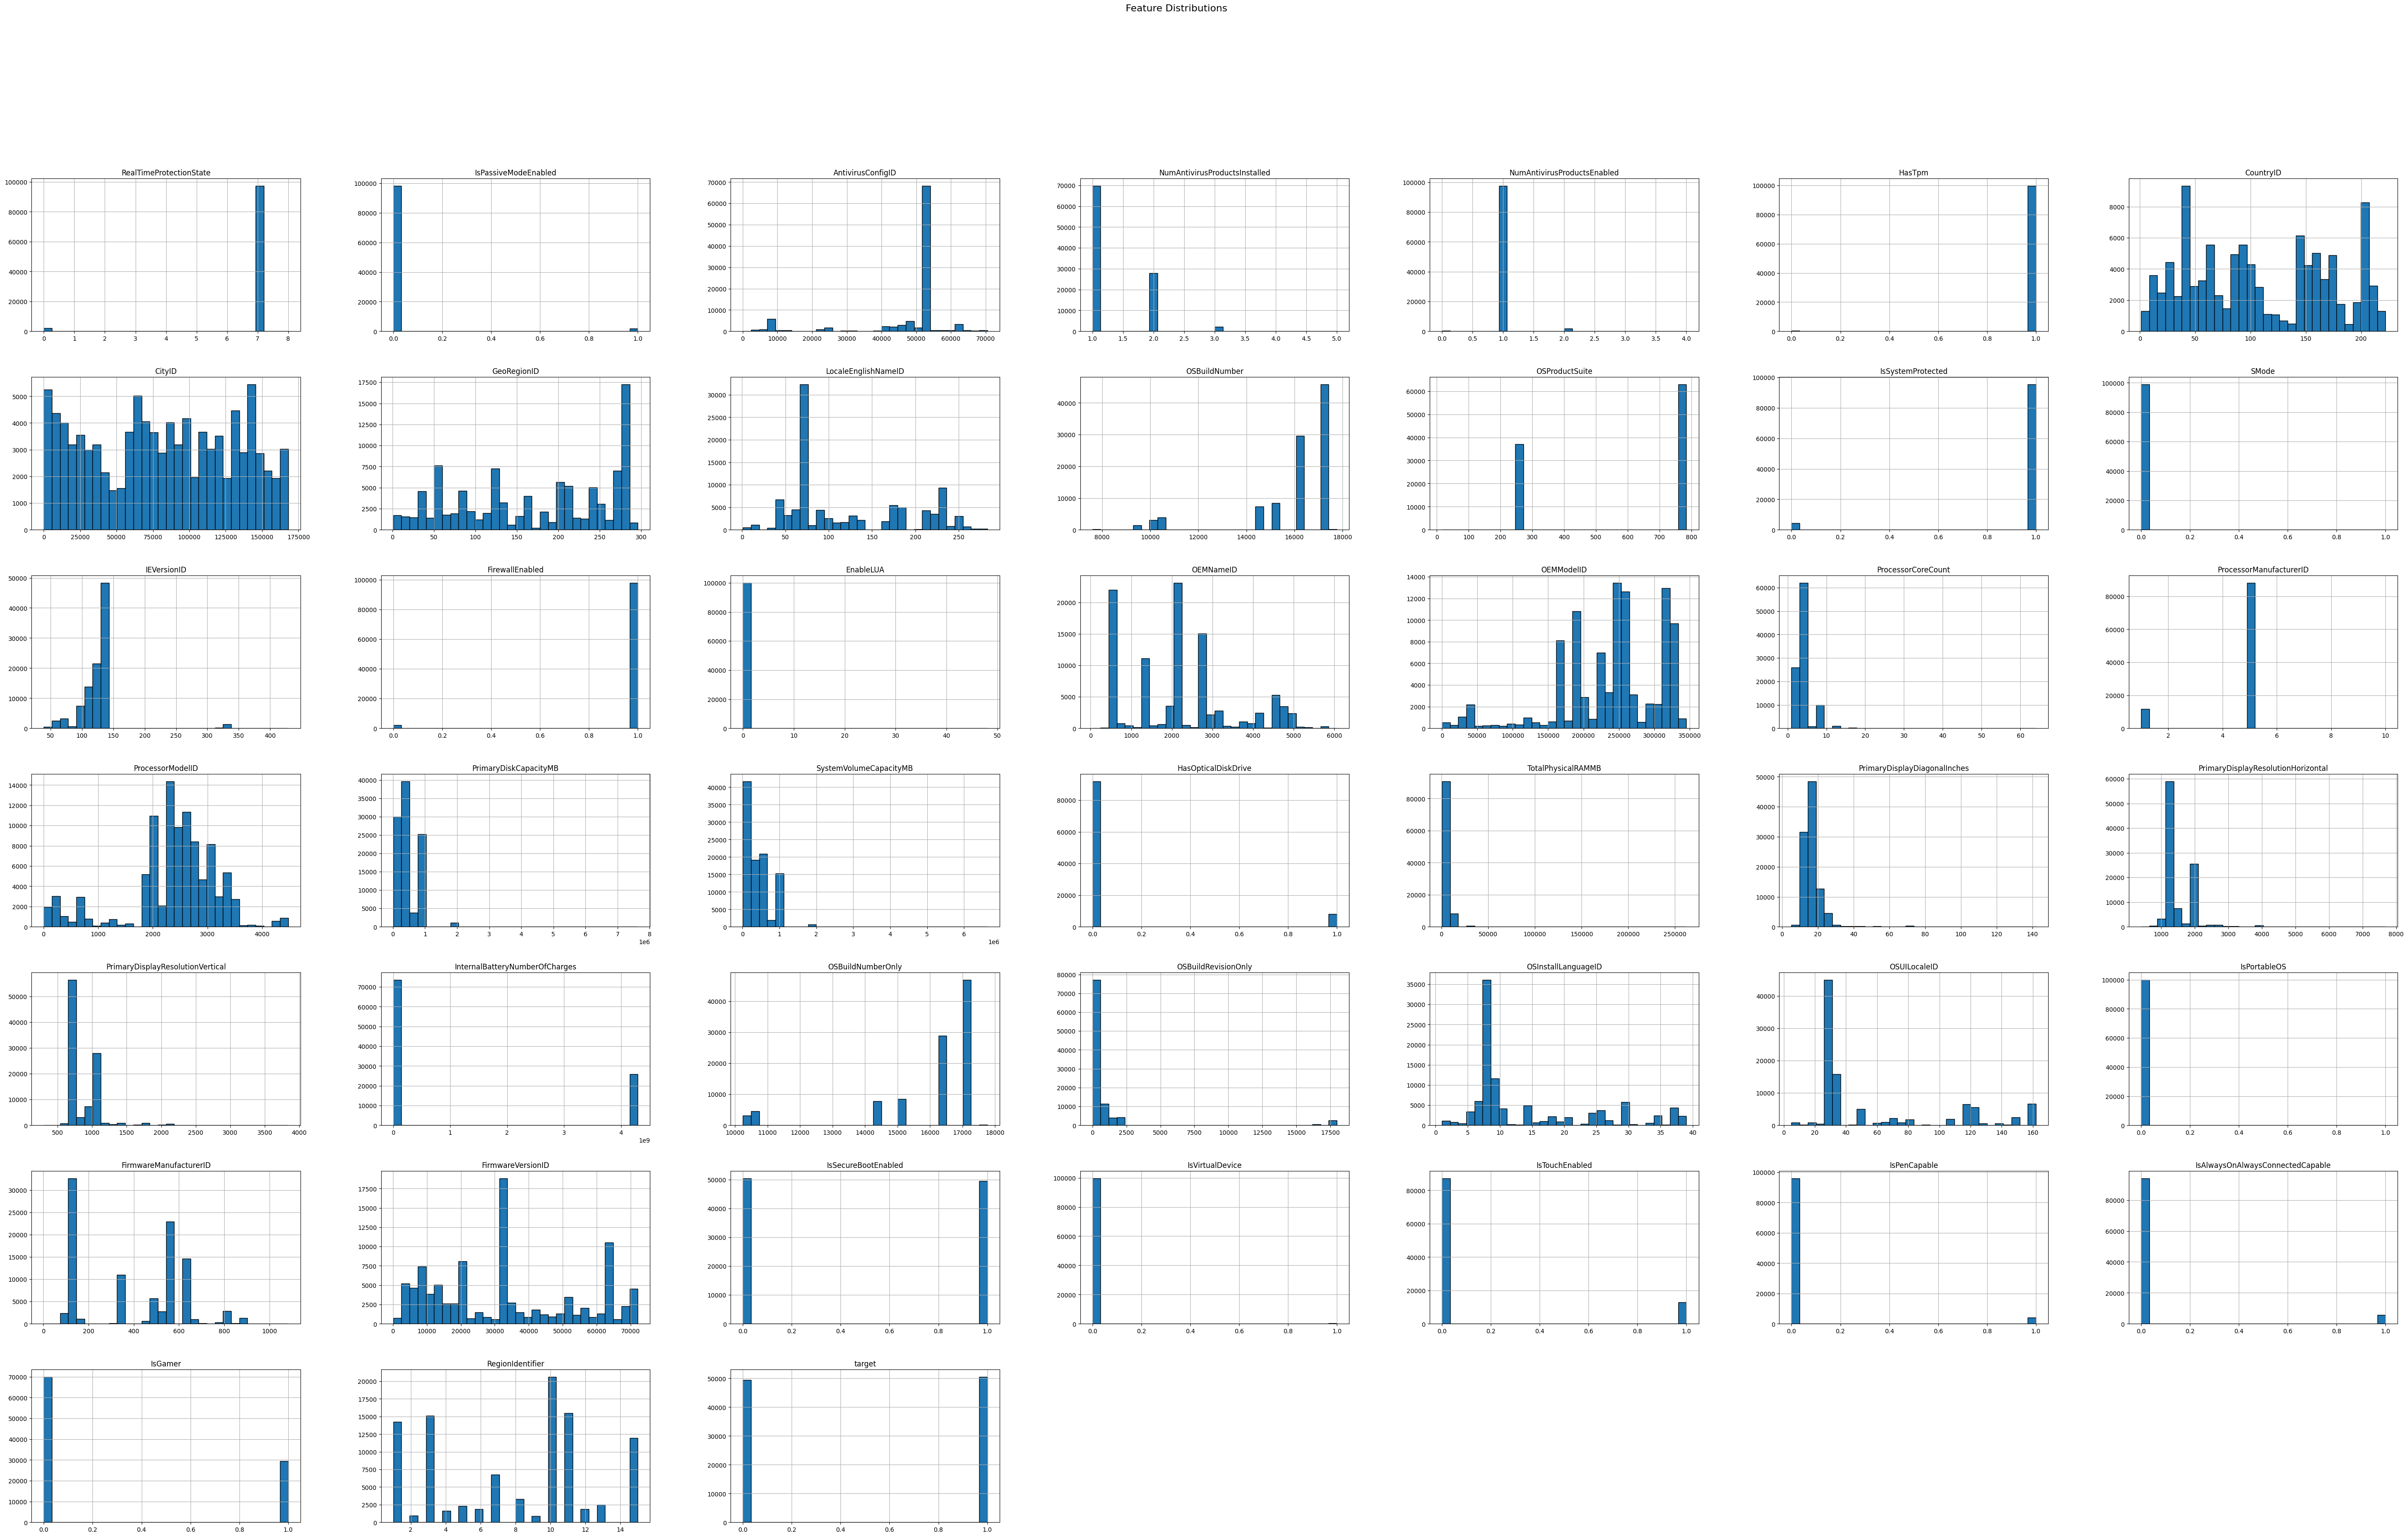

In [11]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
df_train[numeric_cols].hist(figsize=(70, 40), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

Outlier Counts

In [12]:
Q1 = df_train[numerical_cols].quantile(0.25)
Q3 = df_train[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_counts_iqr = ((df_train[numerical_cols] < (Q1 - 1.5 * IQR)) |
(df_train[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

print("\nOutlier Counts (IQR Method):")
print(outlier_counts_iqr[outlier_counts_iqr > 0])


Outlier Counts (IQR Method):
RealTimeProtectionState                2559
IsPassiveModeEnabled                   1762
AntivirusConfigID                     19581
NumAntivirusProductsInstalled            96
NumAntivirusProductsEnabled            2259
HasTpm                                  322
OSBuildNumber                         15982
IsSystemProtected                      4464
SMode                                    50
IEVersionID                            4949
FirewallEnabled                        1990
EnableLUA                               487
OEMNameID                             10270
OEMModelID                              747
ProcessorCoreCount                    11142
ProcessorManufacturerID               11735
ProcessorModelID                      10931
PrimaryDiskCapacityMB                    66
SystemVolumeCapacityMB                  847
HasOpticalDiskDrive                    8140
TotalPhysicalRAMMB                     7094
PrimaryDisplayDiagonalInches          10749
Pr

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Correlation Matrix 

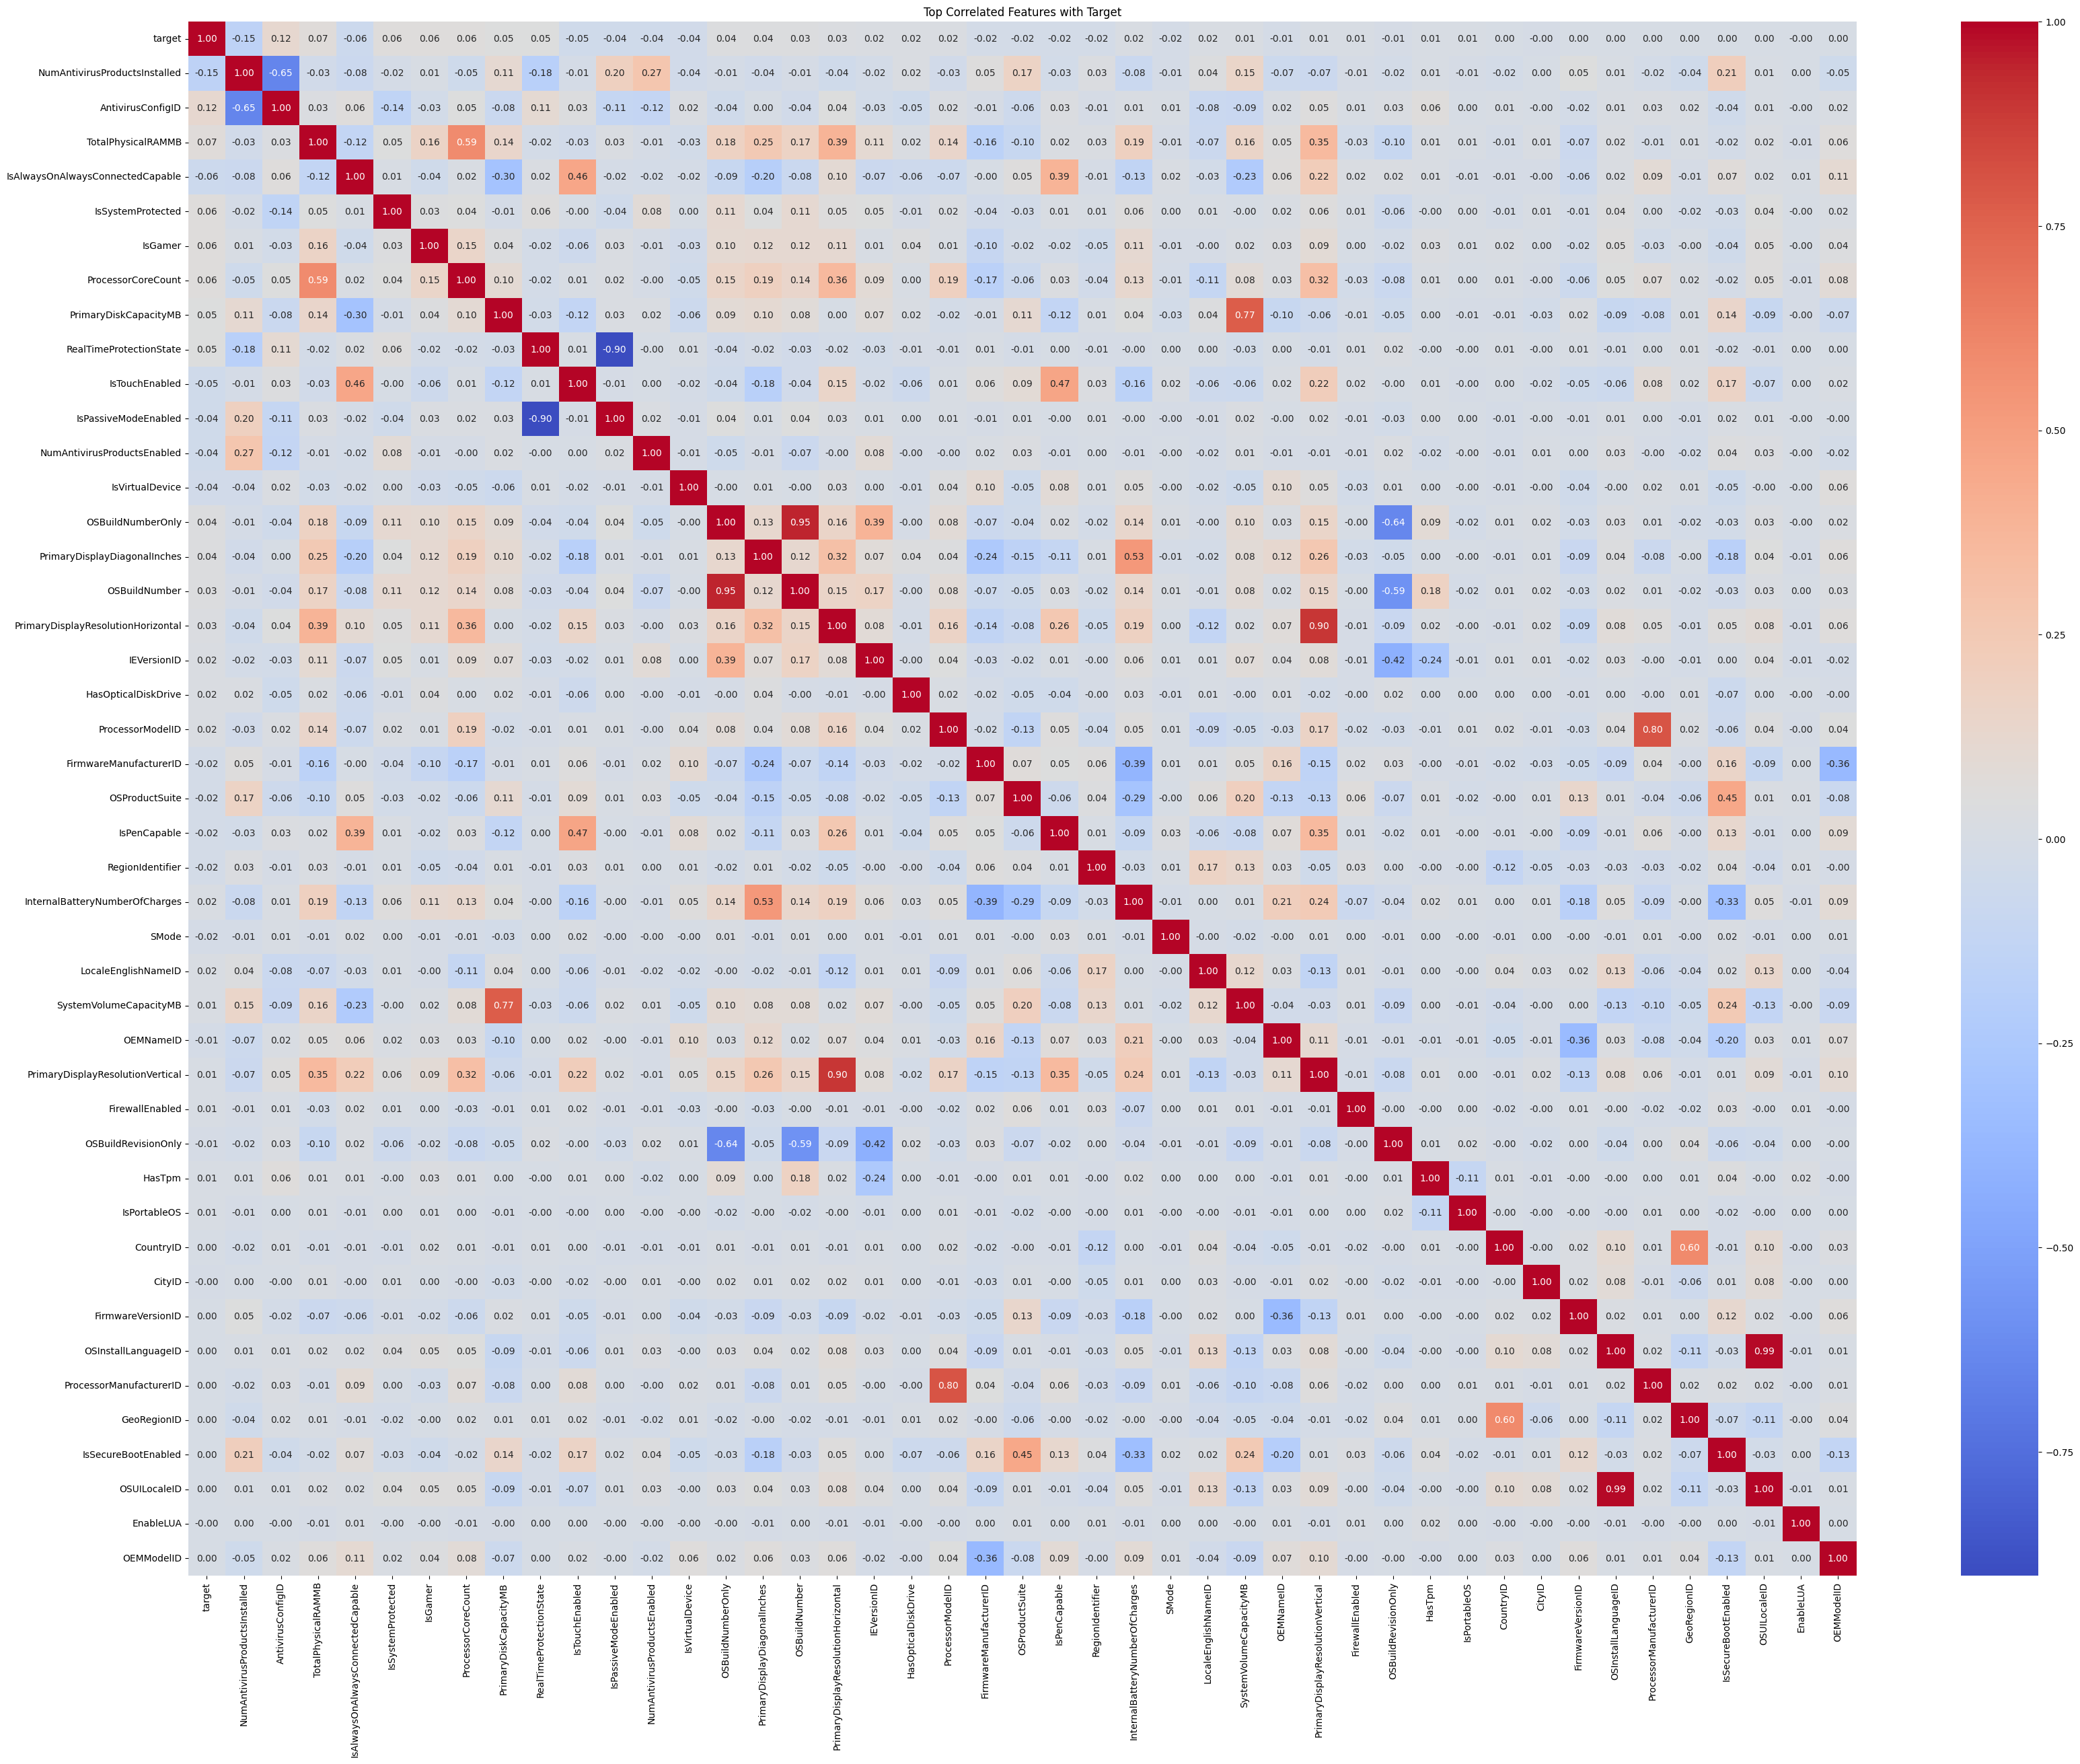

In [13]:
corr_matrix = df_train[numeric_cols].corr()
top_corr_features = corr_matrix['target'].abs().sort_values(ascending=False)
plt.figure(figsize=(40, 30))  # Adjust width and height as needed
sns.heatmap(df_train[top_corr_features.index].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top Correlated Features with Target")
plt.show()

Categorical Features Analysis

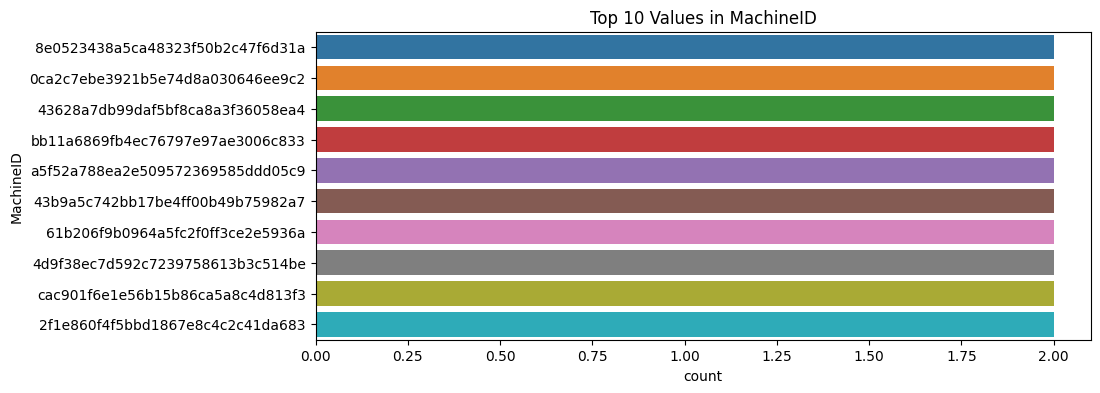

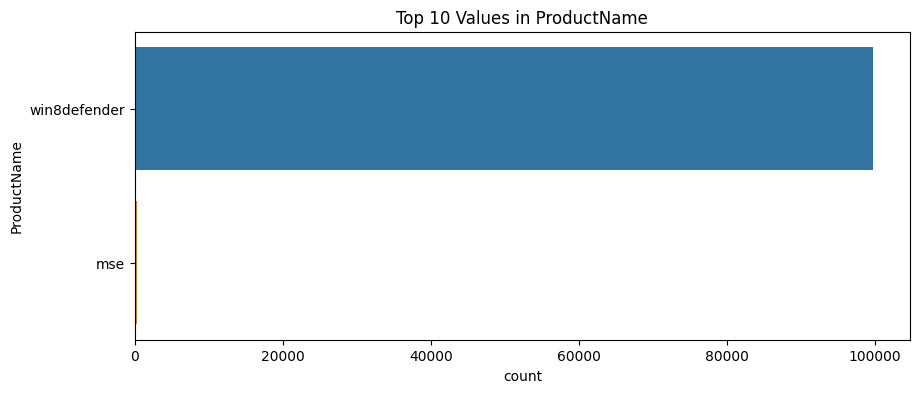

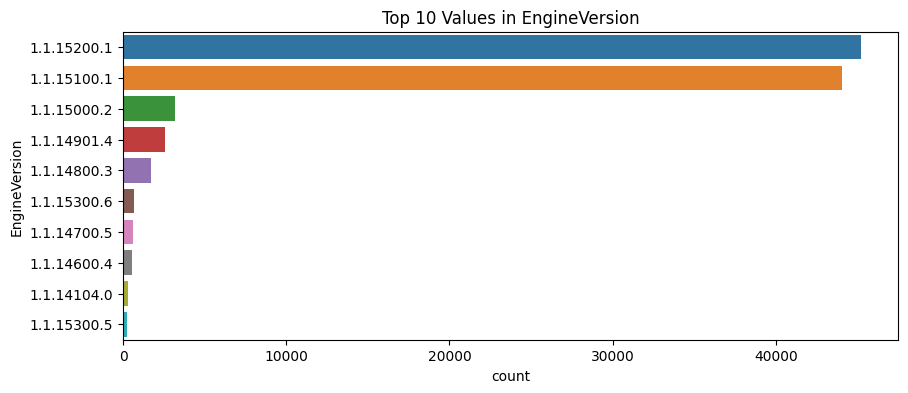

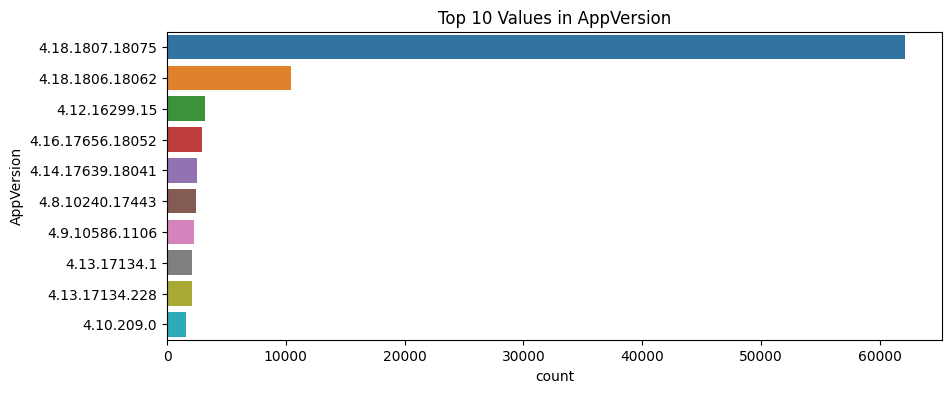

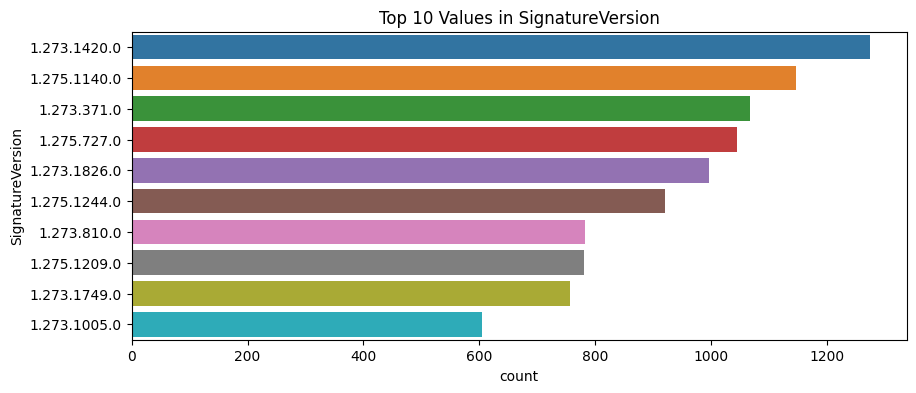

In [14]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols[:5]: 
    plt.figure(figsize=(10, 4))
    sns.countplot(y=df_train[col], order=df_train[col].value_counts().index[:10])
    plt.title(f"Top 10 Values in {col}")
    plt.show()

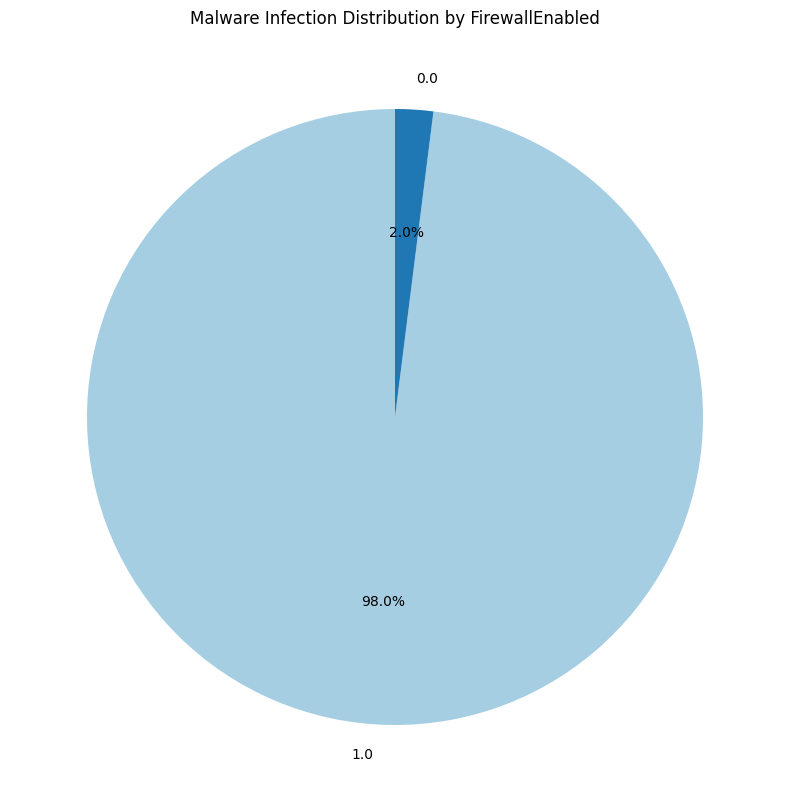

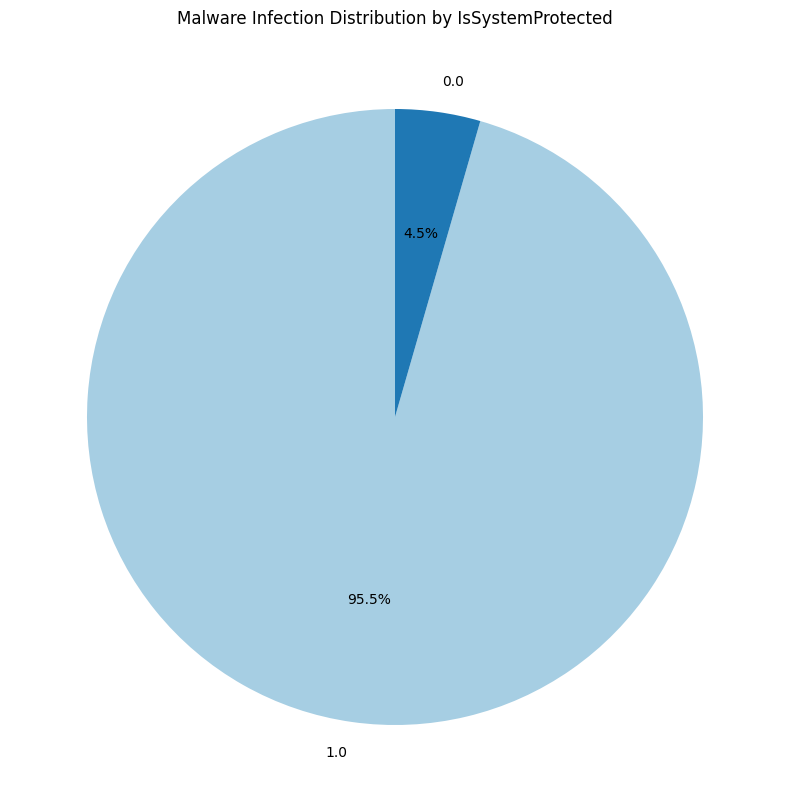

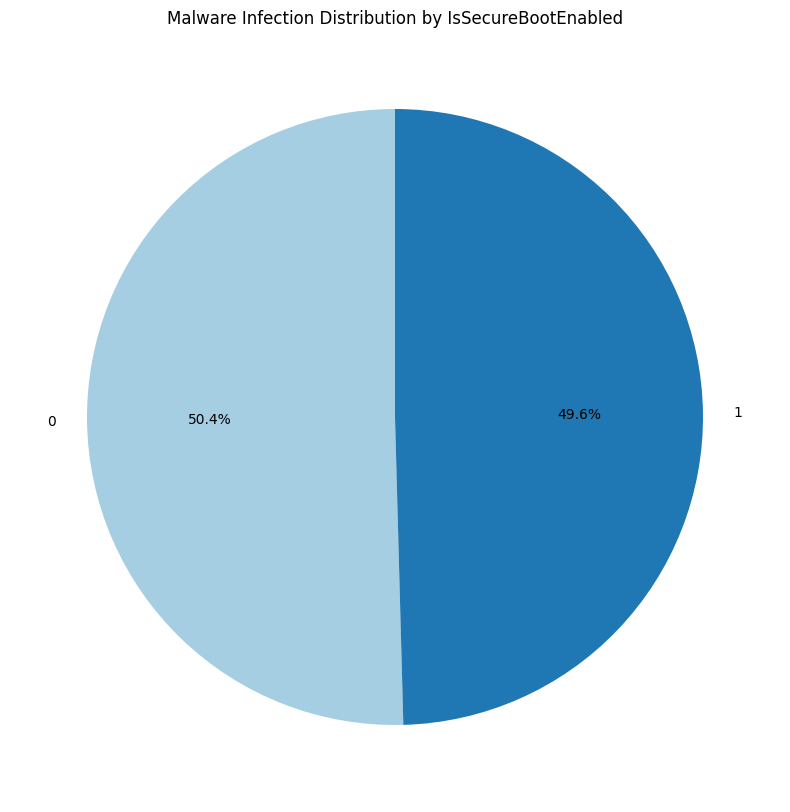

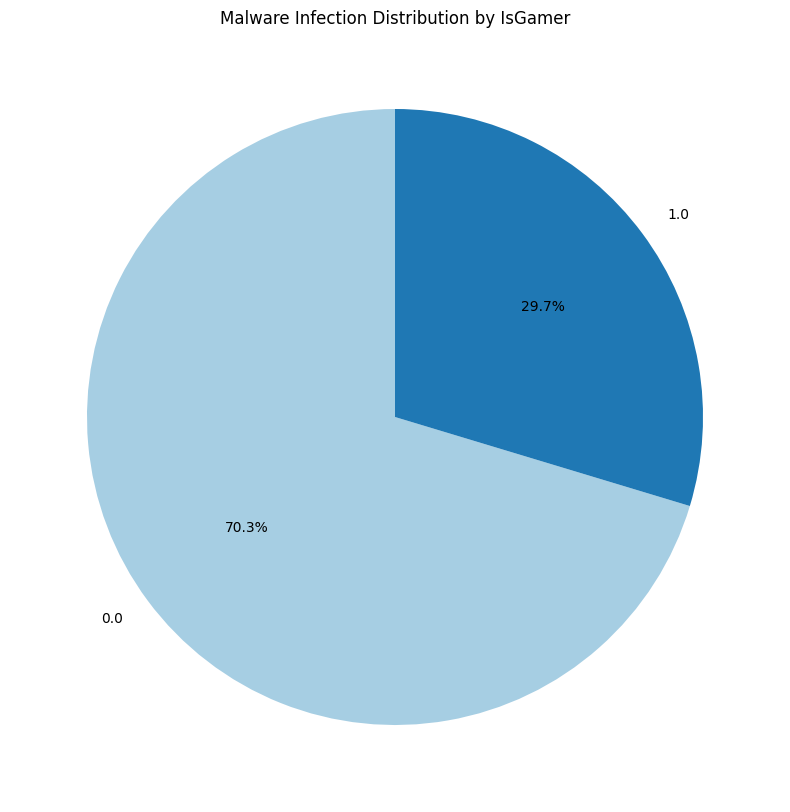

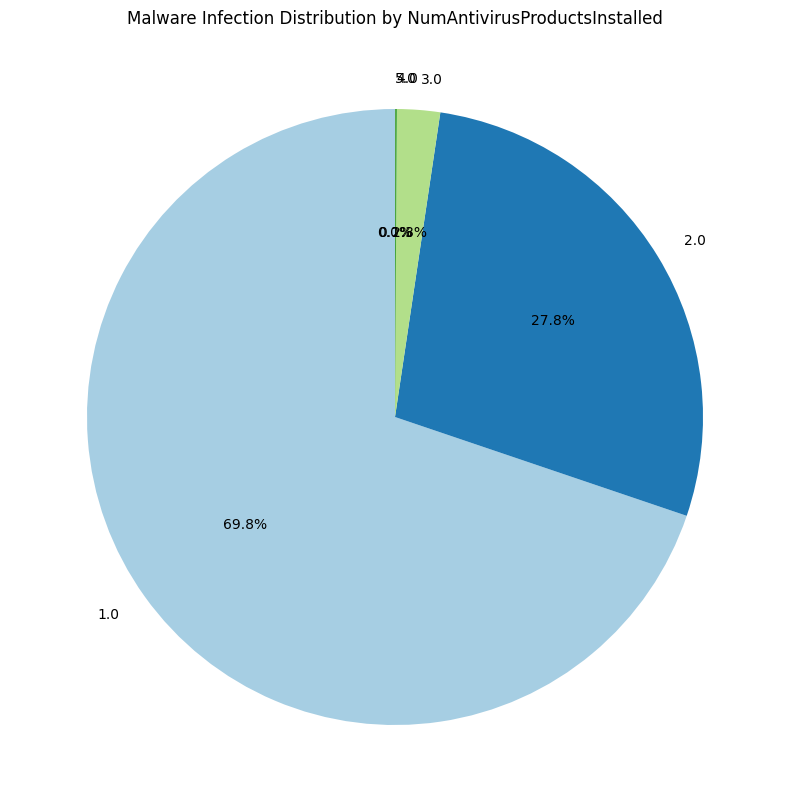

In [15]:
def plot_pie_chart(df, col, top_n=5):
    df_filtered = df.dropna(subset=[col])
    infected = df_filtered[col].value_counts()

    top_n = min(top_n, len(infected))

    top_values = infected.iloc[:top_n]
    other_sum = infected.iloc[top_n:].sum()

    infected_pcts = list(top_values.values)
    labels = list(top_values.index.astype(str))

    if other_sum > 0:
        infected_pcts.append(other_sum)
        labels.append("Other")

    plt.figure(figsize=(10, 10))
    plt.pie(infected_pcts, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Paired.colors[:len(labels)])
    plt.title(f"Malware Infection Distribution by {col}")
    plt.show()


relevant_attributes = ["FirewallEnabled", "IsSystemProtected", "IsSecureBootEnabled", 
                       "IsGamer", "NumAntivirusProductsInstalled"]

for attribute in relevant_attributes:
    plot_pie_chart(df_train, attribute)

In [16]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('target', errors='ignore')

cat_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
num_imputer = SimpleImputer(strategy="constant", fill_value=-1)

df_train.loc[:, categorical_cols] = cat_imputer.fit_transform(df_train[categorical_cols])
df_train.loc[:, numerical_cols] = num_imputer.fit_transform(df_train[numerical_cols])

In [17]:
df_test[categorical_cols] = cat_imputer.transform(df_test[categorical_cols])
df_test[numerical_cols] = num_imputer.transform(df_test[numerical_cols])

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   RealTimeProtectionState             100000 non-null  float64
 6   IsPassiveModeEnabled                100000 non-null  int64  
 7   AntivirusConfigID                   100000 non-null  float64
 8   NumAntivirusProductsInstalled       100000 non-null  float64
 9   NumAntivirusProductsEnabled         100000 non-null  float64
 10  HasTpm                              100000 non-null  int64  
 11  CountryID                  

train test split

In [19]:
df_train.head(10)

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,7.0,0,53447.0,1.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,7.0,0,53447.0,1.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,7.0,0,53447.0,1.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,7.0,0,46413.0,2.0,1.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,7.0,0,40466.0,2.0,1.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0
5,22f549ef938e3a943854d49c853ba918,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1338.0,7.0,0,53447.0,1.0,1.0,...,0,0.0,0,0,0.0,1.0,4.0,2018-09-17 02:29:00,2018-09-11,0
6,d197d1b86b9071b50a655bb3b31cc828,win8defender,1.1.15200.1,4.18.1807.18075,1.275.182.0,7.0,0,53447.0,1.0,1.0,...,0,0.0,0,0,0.0,0.0,11.0,2018-08-26 09:33:00,2018-08-14,0
7,8e3a7d3fe18b946443f0777060f82ab7,win8defender,1.1.15100.1,4.18.1807.18075,1.273.738.0,7.0,0,53447.0,1.0,1.0,...,0,0.0,0,0,0.0,0.0,1.0,2018-08-02 16:51:00,2018-07-16,1
8,bdb0b0d016466c16b3c58ce39da702e1,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1498.0,7.0,0,53447.0,1.0,1.0,...,0,0.0,0,0,0.0,0.0,1.0,2018-08-16 11:38:00,2018-07-10,0
9,44f4b3df4c9ecc13c4a8f3b61f7a18c8,win8defender,1.1.15200.1,4.18.1807.18075,1.275.36.0,7.0,0,53447.0,1.0,1.0,...,1,0.0,0,0,0.0,1.0,1.0,2018-08-23 12:13:00,2018-07-16,1


Count of unique values 

In [20]:
for col in df_train.columns:
    unique_count = df_train[col].nunique(dropna=False)  
    print(f"Column: {col} → Unique Values: {unique_count}")

Column: MachineID → Unique Values: 99835
Column: ProductName → Unique Values: 2
Column: EngineVersion → Unique Values: 37
Column: AppVersion → Unique Values: 69
Column: SignatureVersion → Unique Values: 2735
Column: RealTimeProtectionState → Unique Values: 7
Column: IsPassiveModeEnabled → Unique Values: 2
Column: AntivirusConfigID → Unique Values: 1977
Column: NumAntivirusProductsInstalled → Unique Values: 6
Column: NumAntivirusProductsEnabled → Unique Values: 6
Column: HasTpm → Unique Values: 2
Column: CountryID → Unique Values: 220
Column: CityID → Unique Values: 16048
Column: GeoRegionID → Unique Values: 239
Column: LocaleEnglishNameID → Unique Values: 185
Column: PlatformType → Unique Values: 4
Column: Processor → Unique Values: 3
Column: OSVersion → Unique Values: 7
Column: OSBuildNumber → Unique Values: 24
Column: OSProductSuite → Unique Values: 7
Column: OsPlatformSubRelease → Unique Values: 9
Column: OSBuildLab → Unique Values: 281
Column: SKUEditionName → Unique Values: 8
Colu

In [21]:
drop_columns = [
    'MachineID','OEMModelID','FirmwareVersionID'
]

df_train.drop(columns=drop_columns, inplace=True)
df_test.drop(columns=drop_columns, inplace=True)


print("Dropped ID columns successfully.")


Dropped ID columns successfully.


In [22]:
for col in df_train.columns:
    print(f"Column: {col}")
    print(df_train[col].value_counts(dropna=False)) 
    print("-" * 50) 

Column: ProductName
ProductName
win8defender    99771
mse               229
Name: count, dtype: int64
--------------------------------------------------
Column: EngineVersion
EngineVersion
1.1.15200.1    45219
1.1.15100.1    44017
1.1.15000.2     3169
1.1.14901.4     2597
1.1.14800.3     1719
1.1.15300.6      650
1.1.14700.5      593
1.1.14600.4      569
1.1.14104.0      328
1.1.15300.5      255
1.1.13504.0      212
1.1.14500.5      124
1.1.14405.2       82
1.1.14306.0       56
1.1.14202.0       50
1.1.14003.0       34
1.1.13804.0       33
1.1.13903.0       28
1.1.13303.0       27
1.1.13601.0       26
1.1.13407.0       23
1.1.15000.1       22
1.1.14901.3       22
1.1.13103.0       20
1.1.14305.0       17
1.1.14700.4       16
1.1.12902.0       15
1.1.13704.0       15
1.1.13701.0       15
1.1.13202.0       14
1.1.13000.0       10
1.1.14700.3        9
1.1.14800.1        7
1.1.14500.2        3
1.1.12805.0        2
1.1.13802.0        1
1.1.13803.0        1
Name: count, dtype: int64
--------

In [23]:
threshold = 10  

for col in df_train.select_dtypes(include=['number']).columns: 
    value_counts = df_train[col].value_counts()
    rare_values = value_counts[value_counts < threshold].index
    df_train[col] = df_train[col].replace(rare_values, -999)  

In [24]:
threshold = 10  

for col in df_train.select_dtypes(include=['object']).columns:  
    value_counts = df_train[col].value_counts()
    rare_categories = value_counts[value_counts < threshold].index
    df_train[col] = df_train[col].replace(rare_categories, 'Other')

In [25]:
for col in df_train.columns:
    print(f"Column: {col}")
    print(df_train[col].value_counts(dropna=False)) 
    print("-" * 50)  

Column: ProductName
ProductName
win8defender    99771
mse               229
Name: count, dtype: int64
--------------------------------------------------
Column: EngineVersion
EngineVersion
1.1.15200.1    45219
1.1.15100.1    44017
1.1.15000.2     3169
1.1.14901.4     2597
1.1.14800.3     1719
1.1.15300.6      650
1.1.14700.5      593
1.1.14600.4      569
1.1.14104.0      328
1.1.15300.5      255
1.1.13504.0      212
1.1.14500.5      124
1.1.14405.2       82
1.1.14306.0       56
1.1.14202.0       50
1.1.14003.0       34
1.1.13804.0       33
1.1.13903.0       28
1.1.13303.0       27
1.1.13601.0       26
1.1.13407.0       23
Other             23
1.1.14901.3       22
1.1.15000.1       22
1.1.13103.0       20
1.1.14305.0       17
1.1.14700.4       16
1.1.13701.0       15
1.1.13704.0       15
1.1.12902.0       15
1.1.13202.0       14
1.1.13000.0       10
Name: count, dtype: int64
--------------------------------------------------
Column: AppVersion
AppVersion
4.18.1807.18075     62119
4.18.1

**FEATURE ENGINEERING**

In [26]:
df_train['AntivirusCoverage'] = df_train['NumAntivirusProductsEnabled'] / df_train['NumAntivirusProductsInstalled']
df_train['DiskUsageRatio'] = df_train['SystemVolumeCapacityMB'] / df_train['PrimaryDiskCapacityMB']
df_train['RAMtoDiskRatio'] = df_train['TotalPhysicalRAMMB'] / df_train['PrimaryDiskCapacityMB']


df_test['AntivirusCoverage'] = df_test['NumAntivirusProductsEnabled'] / df_test['NumAntivirusProductsInstalled']
df_test['DiskUsageRatio'] = df_test['SystemVolumeCapacityMB'] / df_test['PrimaryDiskCapacityMB']
df_test['RAMtoDiskRatio'] = df_test['TotalPhysicalRAMMB'] / df_test['PrimaryDiskCapacityMB']

p-value calculation

In [27]:
from scipy.stats import chi2_contingency
import pandas as pd
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    contingency_table = pd.crosstab(df_train[col], df_train['target'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f"{col} has a significant relationship with the target (p={p:.4f})")
    else:
        print(f"{col} has NO strong relationship with the target (p={p:.4f})")

ProductName has NO strong relationship with the target (p=0.1383)
EngineVersion has a significant relationship with the target (p=0.0000)
AppVersion has a significant relationship with the target (p=0.0000)
SignatureVersion has a significant relationship with the target (p=0.0000)
PlatformType has a significant relationship with the target (p=0.0322)
Processor has a significant relationship with the target (p=0.0000)
OSVersion has NO strong relationship with the target (p=0.2083)
OsPlatformSubRelease has a significant relationship with the target (p=0.0000)
OSBuildLab has a significant relationship with the target (p=0.0000)
SKUEditionName has a significant relationship with the target (p=0.0000)
MDC2FormFactor has a significant relationship with the target (p=0.0000)
DeviceFamily has a significant relationship with the target (p=0.0223)
PrimaryDiskType has a significant relationship with the target (p=0.0000)
ChassisType has a significant relationship with the target (p=0.0000)
PowerP

In [28]:
X = df_train.drop(columns=['target', 'ProductName', 'OSVersion', 'OSGenuineState','FlightRing'])
X_test = df_test.drop(columns=['ProductName', 'OSVersion','OSGenuineState', 'FlightRing'])

Hardware & Display Features (Unrelated to Security)

In [29]:
drop_cols = [
    'PrimaryDisplayDiagonalInches',
    'PrimaryDisplayResolutionHorizontal',
    'PrimaryDisplayResolutionVertical',
    'HasOpticalDiskDrive',
    'IsTouchEnabled',
    'IsPenCapable',
    'IsAlwaysOnAlwaysConnectedCapable'
]

df_train.drop(columns=drop_cols, inplace=True)
df_test.drop(columns=drop_cols, inplace=True)


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 66 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ProductName                     100000 non-null  object 
 1   EngineVersion                   100000 non-null  object 
 2   AppVersion                      100000 non-null  object 
 3   SignatureVersion                100000 non-null  object 
 4   RealTimeProtectionState         100000 non-null  float64
 5   IsPassiveModeEnabled            100000 non-null  int64  
 6   AntivirusConfigID               100000 non-null  float64
 7   NumAntivirusProductsInstalled   100000 non-null  float64
 8   NumAntivirusProductsEnabled     100000 non-null  float64
 9   HasTpm                          100000 non-null  int64  
 10  CountryID                       100000 non-null  int64  
 11  CityID                          100000 non-null  float64
 12  GeoRegionID      

# DATA PIPELINE

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce  

X = df_train.drop(columns=['target', 'ProductName', 'OSVersion', 'FlightRing'])
X_test = df_test.drop(columns=['ProductName', 'OSVersion', 'FlightRing'])

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),  
    ('scaler', StandardScaler()) 
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_encoder', ce.TargetEncoder())  
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_cols),
    ('cat', cat_transformer, categorical_cols)
])


pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_processed = pipeline.fit_transform(X, df_train['target'])  
X_test_processed = pipeline.transform(X_test)  # Apply on test


# PCA for Dimensionality Reduction

In [32]:
X_train = X_processed  
y_train = df_train['target']

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test_processed)  

X_train_pca_split, X_val_pca_split, y_train_pca_split, y_val_pca_split = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42
)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


# Linear Models

Logistic Regression

In [33]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_split, y_train_split)


y_pred = log_reg.predict(X_val_split)


print("Logistic Regression Accuracy:", accuracy_score(y_val_split, y_pred))


Logistic Regression Accuracy: 0.62135


SGD Classifier with Hyperparameter Tuning

In [34]:
sgd = SGDClassifier(
    max_iter=500,       
    tol=1e-3,           
    loss='hinge',       
    alpha=0.0001,       
    penalty='l2',       
    learning_rate='optimal', 
    n_jobs=-1,         
    random_state=42,    
    warm_start=True   
)

sgd.fit(X_train_pca_split, y_train_pca_split)


y_pred_sgd = sgd.predict(X_val_pca_split)


print("SGD Accuracy:", accuracy_score(y_val_pca_split, y_pred_sgd))
print(classification_report(y_val_pca_split, y_pred_sgd))


SGD Accuracy: 0.61115
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      9878
           1       0.60      0.70      0.65     10122

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



# Margin-Based Model

Support Vector Classifier with LinearSVC 

In [35]:
svc = LinearSVC(max_iter=5000, dual=False)
svc.fit(X_train_pca_split, y_train_pca_split)
y_pred_svc = svc.predict(X_val_pca_split)

print("SVC Accuracy:", accuracy_score(y_val_pca_split, y_pred_svc))
print(classification_report(y_val_pca_split, y_pred_svc))


SVC Accuracy: 0.61755
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      9878
           1       0.61      0.69      0.64     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



# Neural Networks

Multi-Layer Perceptron (MLP)

In [36]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100,), 
    max_iter=500, 
    alpha=0.01, 
    random_state=42, 
    solver='adam', 
    learning_rate_init=0.01, 
    batch_size=64
)
mlp.fit(X_train_pca_split, y_train_pca_split)
y_pred_mlp = mlp.predict(X_val_pca_split)
print("MLP Accuracy:", accuracy_score(y_val_pca_split, y_pred_mlp))
print(classification_report(y_val_pca_split, y_pred_mlp))

MLP Accuracy: 0.61805
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      9878
           1       0.62      0.65      0.63     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



# Tree-Based Models

Random Forest Classifier

In [37]:
rfc = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    n_jobs=-1, 
    random_state=42
)

rfc.fit(X_train_split, y_train_split)
y_pred_rfc = rfc.predict(X_val_split)

print("Random Forest Accuracy:", accuracy_score(y_val_split, y_pred_rfc))
print(classification_report(y_val_split, y_pred_rfc))


Random Forest Accuracy: 0.62715
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      9878
           1       0.62      0.69      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



Random Forest (Optimized with RandomizedSearchCV)

In [38]:
param_dist = {
    'n_estimators': [50, 100], 
    'max_depth': [10, 20],  
    'min_samples_split': [5, 10],  
    'min_samples_leaf': [2, 4], 
    'max_features': ['sqrt'],  
    'bootstrap': [True]  
}


rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

random_search = RandomizedSearchCV(
    rfc, param_distributions=param_dist, 
    n_iter=10,  
    cv=3,  
    verbose=2,  
    random_state=42,
    n_jobs=-1  
)


random_search.fit(X_train_split, y_train_split)

print("Best Parameters:", random_search.best_params_)


best_rfc = random_search.best_estimator_
y_pred_rfc1 = best_rfc.predict(X_val_split)

print("Optimized Random Forest Accuracy:", accuracy_score(y_val_split, y_pred_rfc1))
print(classification_report(y_val_split, y_pred_rfc1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Optimized Random Forest Accuracy: 0.62975
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      9878
           1       0.62      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



XGBClassifier

In [39]:
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    learning_rate=0.1, 
    n_estimators=200, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    gamma=0.2, 
    reg_lambda=1, 
    reg_alpha=0.5
)
xgb.fit(X_train_split, y_train_split)
y_pred_xgb = xgb.predict(X_val_split)
print("XGBoost Accuracy:", accuracy_score(y_val_split, y_pred_xgb))
print(classification_report(y_val_split, y_pred_xgb))

XGBoost Accuracy: 0.63645
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      9878
           1       0.63      0.67      0.65     10122

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



XGBoost Classifier (Optimized with RandomizedSearchCV)


In [40]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.5, 1, 1.5],
    'scale_pos_weight': [1, np.sum(y_train_split == 0) / np.sum(y_train_split == 1)]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


random_search = RandomizedSearchCV(
    estimator=xgb, param_distributions=param_dist,
    n_iter=20, scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42
)

random_search.fit(X_train_split, y_train_split)


print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)


y_pred_xgb1 = random_search.best_estimator_.predict(X_val_split)
print("Validation Accuracy:", accuracy_score(y_val_split, y_pred_xgb1))
print(classification_report(y_val_split, y_pred_xgb1))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best Accuracy: 0.6308874778531255
Validation Accuracy: 0.63745
              precision    recall  f1-score   support

           0       0.64      0.59      0.62      9878
           1       0.63      0.68      0.65     10122

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



GradientBoostingClassifier

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


gbc = GradientBoostingClassifier(
    learning_rate=0.1, 
    n_estimators=100, 
    max_depth=6, 
    subsample=0.8, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_features='sqrt', 
    random_state=20
)


gbc.fit(X_train_split, y_train_split)


y_pred_gbc = gbc.predict(X_val_split)

print("Gradient Boosting Accuracy:", accuracy_score(y_val_split, y_pred_gbc))
print(classification_report(y_val_split, y_pred_gbc))

Gradient Boosting Accuracy: 0.63225
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      9878
           1       0.63      0.68      0.65     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



#  Ensemble Models 

Stacking Classifier

In [42]:
base_models = [
    ('xgb', XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, n_jobs=-1, tree_method='hist')),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.01, random_state=42, solver='adam', learning_rate_init=0.01, batch_size=64))
]


meta_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3)

stack_model.fit(X_train_split, y_train_split)

y_pred_stack = stack_model.predict(X_val_split)
print("Stacking Classifier Accuracy:", accuracy_score(y_val_split, y_pred_stack))
print(classification_report(y_val_split, y_pred_stack))

Stacking Classifier Accuracy: 0.63645
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      9878
           1       0.64      0.66      0.65     10122

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



In [43]:
submission = pd.DataFrame({'id': df_test.index, 'target': stack_model.predict(X_test_processed)})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


Voting Classifier

In [44]:
from sklearn.ensemble import VotingClassifier

base_models = [
    ('xgb', XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, n_jobs=-1, tree_method='hist')),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.01, random_state=42, solver='adam', learning_rate_init=0.01, batch_size=64)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1))
]

voting_model = VotingClassifier(estimators=base_models, voting='soft') 


voting_model.fit(X_train_split, y_train_split)


y_pred_voting = voting_model.predict(X_val_split)

print("Voting Classifier Accuracy:", accuracy_score(y_val_split, y_pred_voting))
print(classification_report(y_val_split, y_pred_voting))


Voting Classifier Accuracy: 0.63155
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      9878
           1       0.63      0.66      0.64     10122

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



# Model Accuracy Comparison (Visualization)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


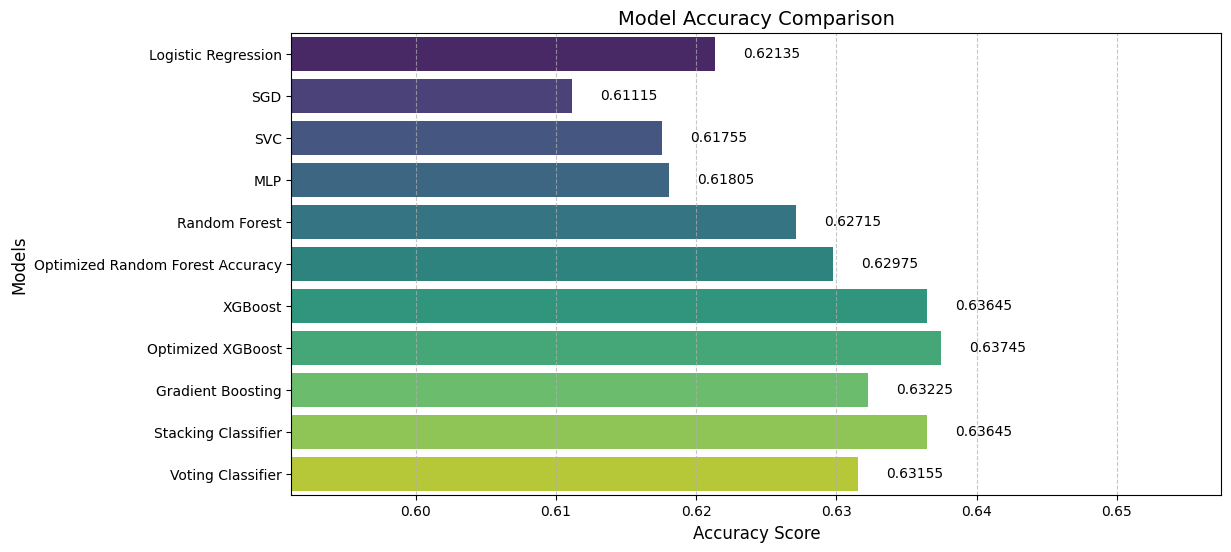

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

models = ["Logistic Regression","SGD","SVC","MLP", "Random Forest","Optimized Random Forest Accuracy","XGBoost", "Optimized XGBoost", "Gradient Boosting","Stacking Classifier","Voting Classifier"]
accuracies = []

accuracies.append(accuracy_score(y_val_split, y_pred))
accuracies.append(accuracy_score(y_val_pca_split, y_pred_sgd))
accuracies.append(accuracy_score(y_val_pca_split, y_pred_svc))
accuracies.append(accuracy_score(y_val_pca_split, y_pred_mlp))

accuracies.append(accuracy_score(y_val_split, y_pred_rfc))
accuracies.append(accuracy_score(y_val_split, y_pred_rfc1)) 

accuracies.append(accuracy_score(y_val_split, y_pred_xgb))
accuracies.append(accuracy_score(y_val_split, y_pred_xgb1))  

accuracies.append(accuracy_score(y_val_split, y_pred_gbc))
accuracies.append(accuracy_score(y_val_split, y_pred_stack))
accuracies.append(accuracy_score(y_val_split, y_pred_voting))


plt.figure(figsize=(12, 6))
sns.barplot(x=accuracies, y=models, palette="viridis")

for index, value in enumerate(accuracies):
    plt.text(value + 0.002, index, f"{value:.5f}", va='center', fontsize=10)


plt.xlabel("Accuracy Score", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlim(min(accuracies) - 0.02, max(accuracies) + 0.02)  
plt.grid(axis='x', linestyle="--", alpha=0.7)


plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


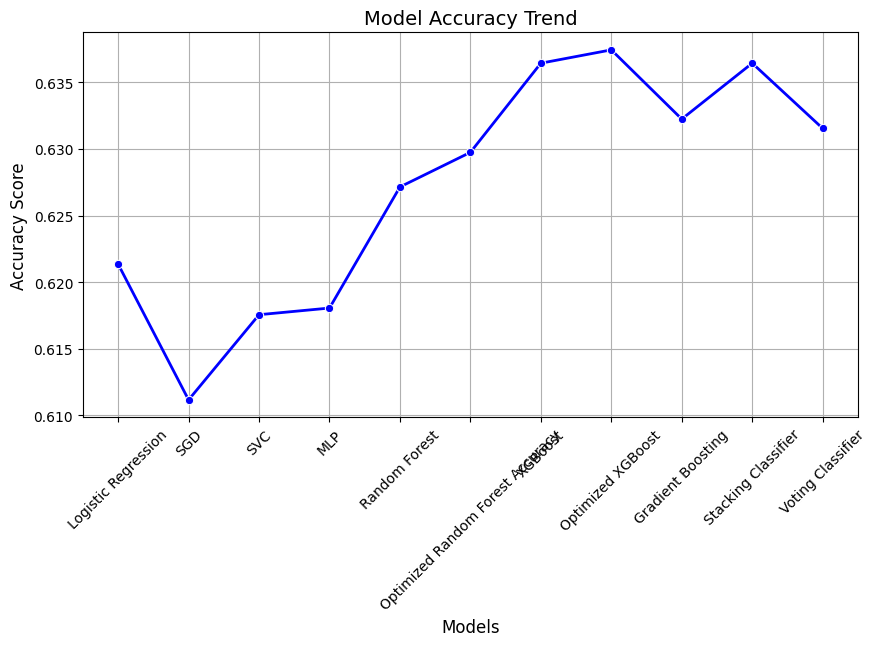

In [46]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=models, y=accuracies, marker='o', linewidth=2, color='b')
plt.xticks(rotation=45)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Model Accuracy Trend", fontsize=14)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


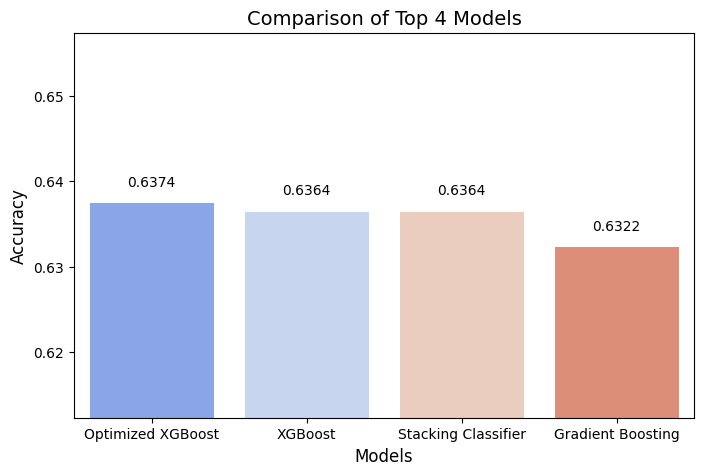

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

model_accuracies = {
    "Logistic Regression" : accuracy_score(y_val_split, y_pred),
    "SVC": accuracy_score(y_val_split, y_pred_svc),
    "Random Forest": accuracy_score(y_val_split, y_pred_rfc),
    "Optimized Random Forest": accuracy_score(y_val_split, y_pred_rfc1),
    "SGD": accuracy_score(y_val_split, y_pred_sgd),
    "MLP": accuracy_score(y_val_split, y_pred_mlp),
    "XGBoost": accuracy_score(y_val_split, y_pred_xgb),
    "Optimized XGBoost": accuracy_score(y_val_split, y_pred_xgb1),
    "Gradient Boosting": accuracy_score(y_val_split, y_pred_gbc),
    "Stacking Classifier": accuracy_score(y_val_split, y_pred_stack),
    "Voting Classifier": accuracy_score(y_val_split, y_pred_voting)
}


top_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)[:4]

model_names, accuracies = zip(*top_models)

plt.figure(figsize=(8,5))
sns.barplot(x=list(model_names), y=list(accuracies), palette="coolwarm")

plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Comparison of Top 4 Models", fontsize=14)
plt.ylim(min(accuracies) - 0.02, max(accuracies) + 0.02) 

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.002, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()


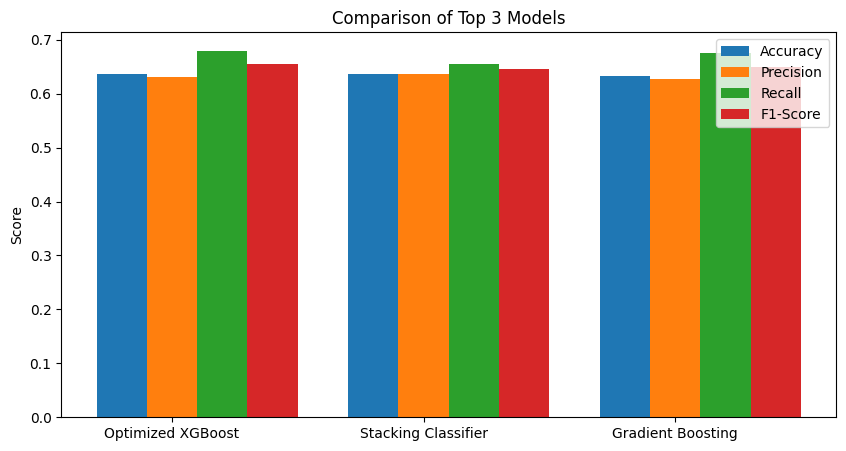

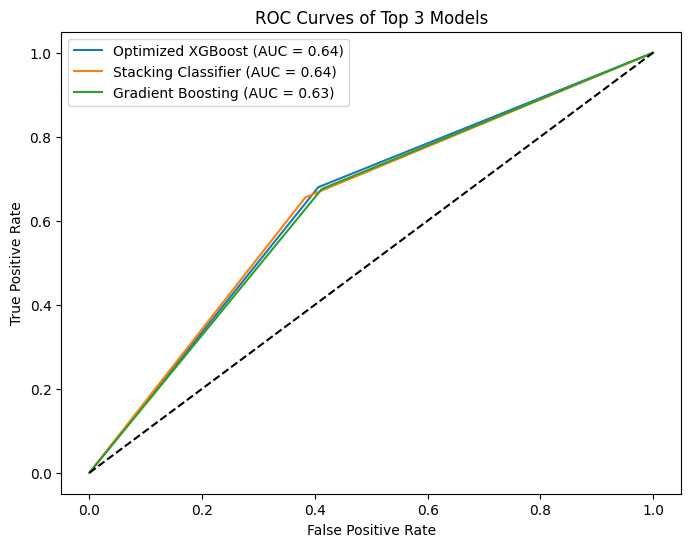

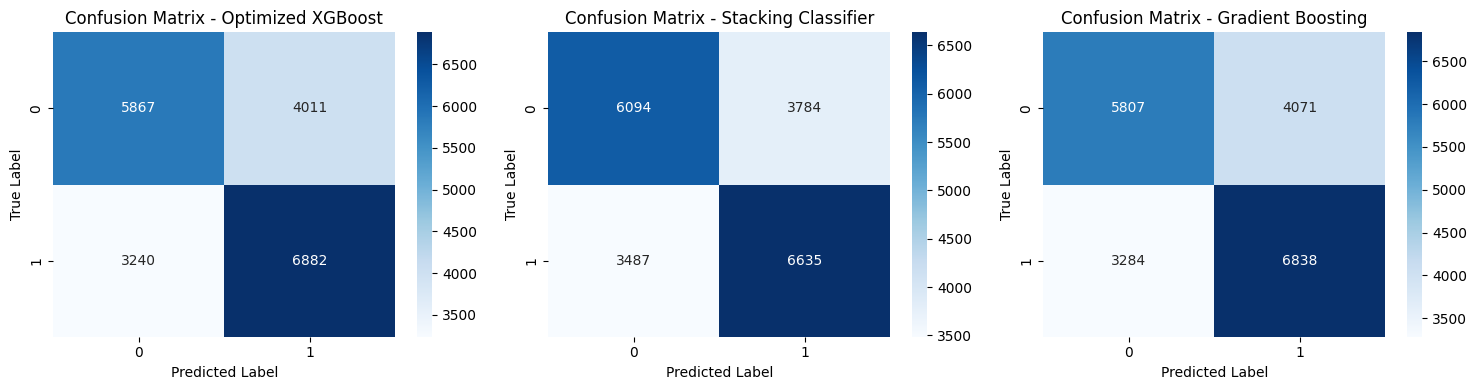

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

top_models = {
    "Optimized XGBoost": y_pred_xgb1,
    "Stacking Classifier" : y_pred_stack,
    "Gradient Boosting": y_pred_gbc
}


metrics = {}
for model_name, y_pred in top_models.items():
    metrics[model_name] = {
        "Accuracy": accuracy_score(y_val_split, y_pred),
        "Precision": precision_score(y_val_split, y_pred),
        "Recall": recall_score(y_val_split, y_pred),
        "F1-Score": f1_score(y_val_split, y_pred)
    }


metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]
metric_values = np.array([[metrics[m][metric] for metric in metric_names] for m in top_models])


plt.figure(figsize=(10, 5))
x = np.arange(len(top_models))
width = 0.2

for i, metric in enumerate(metric_names):
    plt.bar(x + i * width, metric_values[:, i], width, label=metric)

plt.xticks(x + width, list(top_models.keys()))
plt.ylabel("Score")
plt.title("Comparison of Top 3 Models")
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
for model_name, y_pred in top_models.items():
    fpr, tpr, _ = roc_curve(y_val_split, y_pred)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of Top 3 Models")
plt.legend()
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (model_name, y_pred) in zip(axes, top_models.items()):
    cm = confusion_matrix(y_val_split, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


Optimized XGBoost has the best Recall (0.63), F1-score (0.635), and AUC (0.64).
Stacking Classifier has slightly higher precision and comparable AUC.

**Therefore the Stacking Classifier was chosen as the final model due to its ability to leverage the strengths of multiple classifiers, resulting in a more robust and generalizable prediction system.With accuracy (0.635) and recall (0.61), the model maintains a good balance between detecting malware.**

